# Querying terrain data for LoRaWAN links in Antwerp

This notebook uses ``proppy.raster`` to query high-dimensional terrain data for each line-segment.

The file uses a dataset of LoRaWAN transmissions in Antwerp, ``antwerp_links.geojson``. These have:
- ``GeoPandas.GeoSeries`` data for each line-segment (in UTM coordinates).
- Elevation data (in m) for the head and tail of each line-segment.

Data is queried from a digital surface model (DSM) raster, in the same coorinate system as the link data.


In [1]:
# import packages
import pandas as pd
import geopandas as gpd
import contextily as cx
from functools import partial
from multiprocessing import Pool
from time import perf_counter

import matplotlib.pyplot as plt

import proppy.raster as prs

In [2]:
# input data files
linksfile = "/Users/sander/Desktop/lora-tools/antwerp_links.geojson"
rasterfile = "/Volumes/Transcend/lora/data/antwerp-gis/dsm-1m-clipped.tif"

In [3]:
# Load link data
links = gpd.read_file(linksfile)

links = links.rename(columns = {'ele_tr': 'zhead', 'ele_gw':'ztail'})

In [4]:
def load_and_process(links, rasterfile, rel_buffer=0.1,
                     ncols=100, nrows=20, maxsize=None
                     ):
    """Equip links with geodata from raster.
    """    

    links = links.reset_index(drop=True)
    
    #print(f"Loaded links (shape={links.shape}) with CRS {links.crs}.")

    # Verify presence of necessary columns
    linkcols = set(links.columns)

    if 'geometry' not in linkcols:
        raise ValueError("Provided `linksfile` must have a `geometry`-column.")
    
    if 'zhead' not in linkcols:
        raise ValueError("Provided `linksfile` must have  a `zhead`-column.")
    
    if 'ztail' not in linkcols:
        raise ValueError("Provided `linksfile` must have  a `ztail`-column.")

    # Collect relevant columns
    lines = links.geometry
    zheads, ztails = links["zhead"].values, links["ztail"].values

    # Compute rectangle features
    rectangles = prs.make_rectangles(lines, zheads, ztails, relative_buffer=rel_buffer)

    # Main "loop" using multiprocessing
    fun_kwargs = {"nrows": nrows, "ncols": ncols, "rasterfile": rasterfile}

    t_start = perf_counter()  # time run

    if maxsize is None:
        maxsize = len(rectangles)

    with Pool() as p:
        out = p.map(
            partial(prs.normalizedRasterValues, **fun_kwargs), rectangles[:maxsize]
        )

    t_stop = perf_counter()
    duration = t_stop - t_start

    for output in out:

        i = output['id']

        rectangles[i].points = gpd.GeoSeries(output['points'])
        rectangles[i].point_vals = output['vals']


    return rectangles[:maxsize], duration

In [11]:
# process the data (can take a while)
rectangles, duration = load_and_process(
    links, rasterfile, maxsize=10, ncols=250, nrows=20, rel_buffer=0.05
)

In [12]:
rect = rectangles[0]

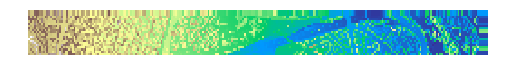

In [13]:
rect.plot_vals()

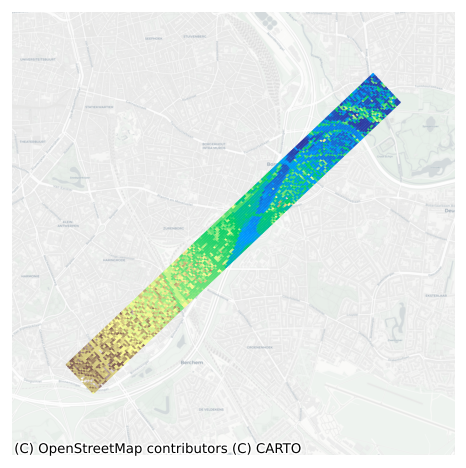

In [14]:
rect.plot_map(links.crs, markersize=10)

In [ ]:
# Collect points vals only and save

out = [{'id':r.id, 'data':r.point_vals} for r in rectangles]

df = pd.DataFrame.from_records(out, index='id')

df = pd.DataFrame(df['data'].to_list(), columns=list(range(len(out[0]['data']))))

print(f"Saving dataframe of shape {df.shape}.")

df.to_csv("../../data/antwerp_geodata.csv")

In [ ]:
def load_and_process(relative_buffer=0.5, ncols=100, nrows=20):
    # input data files
    links_file = "/Users/sander/Desktop/lora-tools/antwerp_links.geojson"
    path_raster = "/Volumes/Transcend/lora/data/antwerp-gis/dsm-1m-clipped.tif"

    # Load link data from file
    links = gpd.read_file(links_file)
    links = links.reset_index(drop=True)

    print(f"Loaded links (shape={links.shape}) with CRS {links.crs}.")

    # Link feautres
    lengths = links["distance"].values
    lines = links.geometry
    zheads, ztails = links["ele_tr"].values, links["ele_gw"].values

    # Compute rectangle features
    buffers = lengths * relative_buffer
    angles = prs.angle(lines)
    rects = prs.makeParallelRectangles(lines.values, angles, buffers)
    consts, slopes = prs.getSlope(lines, angles, zheads, ztails)

    # Form Rectangle-objects
    rectangles = []
    for i, _ in enumerate(rects):
        R = prs.Rectangle(i, rects[i], angles[i], consts[i], slopes[i], lengths[i])
        rectangles.append(R)

    # Main "loop" using multiprocessing
    fun_kwargs = {"nrows": nrows, "ncols": ncols, "rasterfile": path_raster}

    t_start = perf_counter()  # time run

    with Pool() as p:
        out = p.map(
            partial(prs.normalized_raster_values, **fun_kwargs), rectangles
        )

    t_stop = perf_counter()
    duration = t_stop - t_start

    return out, duration

In [ ]:
# process the data (can take a while)
out, duration = load_and_process()

In [ ]:
# expand list column and save
df = pd.DataFrame.from_records(out, index='id')

df = pd.DataFrame(df['data'].to_list(), columns=list(range(len(out[0]['data']))))

print(f"Saving dataframe of shape {df.shape}.")

df.to_csv("../../data/antwerp_geodata.csv")

In [ ]:
# load data to verify save is good
df2 = pd.read_csv("../../data/antwerp_geodata.csv")

print(f"Loded dataframe of shape {df2.shape}.")